STARTED:      1/30/25

LAST UPDATED: 1/30/25

By Eugene Fong

# TUTORIAL - SCANPY

SOURCE: [https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

### INSTALLS

In [ ]:
%pip install pooch
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


### IMPORTS

In [3]:
import scanpy as sc
import anndata as ad
import pooch

### PREPROCESSING AND CLUSTERING

In [4]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

In [5]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache('scverse_tutorials'),
    base_url='doi:10.6084/m9.figshare.22716739.v1/',
)
EXAMPLE_DATA.load_registry_from_doi()

In [6]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/data/fonge2/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### QC

In [9]:
# Mitochondrial genes "MT-" for human
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith (('RPS', 'PRL'))

# Hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]')

In [12]:
# CALCULATE - QC Metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars = ['mt', 'ribo', 'hb'],
    inplace = True,
    log1p = True
)

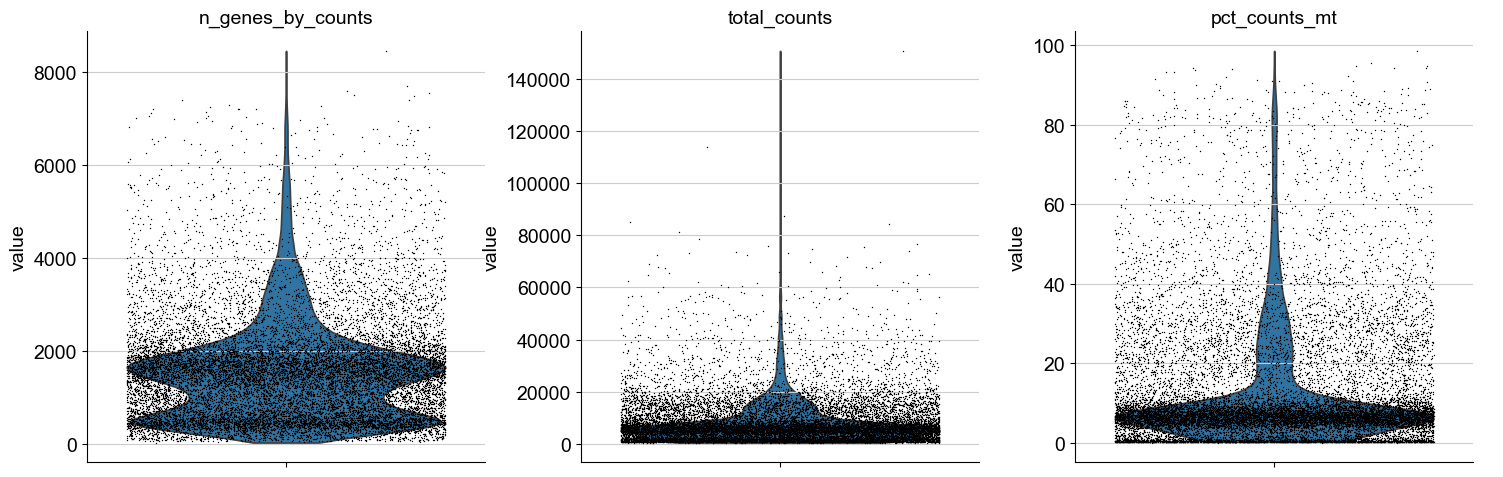

In [11]:
# PLOT - violin plot of QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter = 0.4,
    multi_panel = True,
)

Useful to consider QC metrics jointly by inspecting a scatter plot colored by `pct_counts_mt`

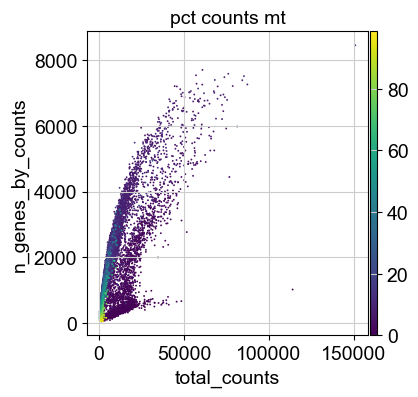

In [14]:
sc.pl.scatter(
    adata,
    'total_counts',
    'n_genes_by_counts',
    color = 'pct_counts_mt'
)

Then remove cells w/too many mito genes using thresholds

In [17]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata, min_cells = 3)

### DOUBLET DETECTION

- Doublets can lead to miscalculations/distortions downstream
- Scanpy uses Scrublet which uses NN to predict cell doublets
- `scanpy.pp.scrublet()` adds `doublet_score` and `predicted_doublet` to `.obs`

One can now either filter directly on predicted_doublet or use the doublet_score later during clustering to filter clusters with high doublet scores.

In [19]:
# Run scrublet for doublet detection
sc.pp.scrublet(
    adata,
    batch_key = 'sample'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 98.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cellpose 2.2.3 requires fastremap, which is not installed.
cellpose 2.2.3 requires opencv-python-headless, which is not installed.
cellpose 2.2.3 requires torch>=1.6, which is not installed.
vpt-plugin-cellpose2 1.0.0 requires torch==2.0.0, which is not installed.
vpt-plugin-cellpose2 1.0.0 requires vpt_core>=1.1.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


### NORMALIZATION

Common approach is count depth scaling w/log plus one (log1p) transformation

- Count depth scaling normalizes the data to a "size factor" (such as median)
- Size factor controlled via `target_sum` in `pp.normalize_total`

In [20]:
# Saving count data
adata.layers['counters'] = adata.X.copy()

In [21]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

### FEATURE SELECTION

Reduce dimensionality and keep only the most informative genes

- `pp.highly_variable_genes` annotates highly variable genes by reproducing implementations of Seurat, Cell Ranger and Seurat based on your `flavor`

In [22]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes = 2000,
    batch_key = 'sample'
)

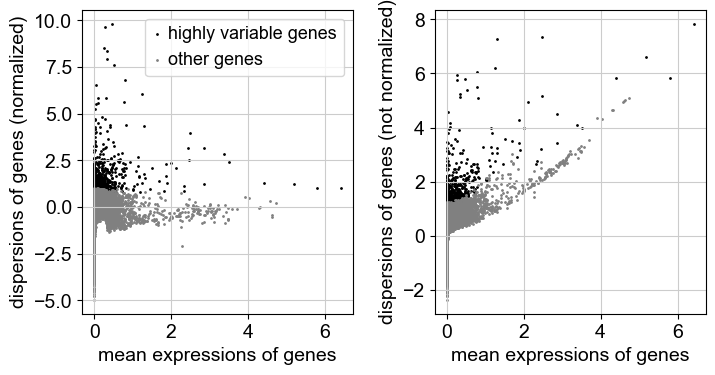

In [25]:
sc.pl.highly_variable_genes(adata)

### DIMENSIONALITY REDUCTION

Reduces the dimensions by running PCA

In [24]:
sc.tl.pca(adata)

Inspect the contribution of single PCs to the total variance.